<h1 style="max-width: 900px; margin: auto; text-align: center;">
    US Dollar to Japanese Yen Rate Prediction Model
</h1>

This section of the project will explore the use of machine learning to predict the exchange rate between the US dollar ($) to Japanese yen (¥). This project uses a dataset of USD / JPY conversion rates from a ten-year period between 2015 and 2024.

## Data Analysis

### Load Packages and Set Device

In [1]:
# Standard Libraries
import random
import time

# Data Manipulation & Analysis
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import yfinance as yf
from matplotlib.lines import Line2D

# PyTorch for Model Implementation
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset

# Sklearn Utilities for Clustering and Preprocessing
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.cluster import KMeans, AgglomerativeClustering
from sklearn.metrics import mean_absolute_error, mean_absolute_percentage_error

# Set the device to CUDA if available, otherwise fallback to CPU
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Device: {device}")

Device: cpu


### Read and Preview the Data

Obtain a 10-year data window for the USD / JPY exchange rate from Yahoo Finance, keeping only the Date and Close values. Read it and check its dimensions; the number of rows (days) and number of columns (features).

In [2]:
# Obtain the Data from Yahoo Finance
ticker = 'JPY=X'
d_start = '2015-01-01'
d_end = '2024-12-31'

yen = yf.download(ticker, start=d_start, end=d_end, interval='1d', progress=False, auto_adjust=True)
#yen = pd.read_csv('yenrate.csv', parse_dates=['Date']) # If Yahoo Finance doesn't work

if isinstance(yen.columns, pd.MultiIndex):
    yen.columns = yen.columns.droplevel(1)
yen = yen.reset_index()

yen = yen[['Date', 'Close']] # Keep only Date and Close

In [3]:
print("Days:", yen.shape[0])
print("Features:", yen.shape[1])

Days: 2605
Features: 2


The dataset contains 2,605 days (10 years) with 2 features: Date, and Close. Exactly what we need.

We can preview the data and check basic statistics to ensure data integrity.

In [7]:
yen

Price,Date,Close
0,2015-01-01,119.672997
1,2015-01-02,119.870003
2,2015-01-05,120.433998
3,2015-01-06,119.425003
4,2015-01-07,118.672997
...,...,...
2600,2024-12-24,157.164993
2601,2024-12-25,157.106995
2602,2024-12-26,157.132996
2603,2024-12-27,157.748001


Plot the data on a time-series graph.

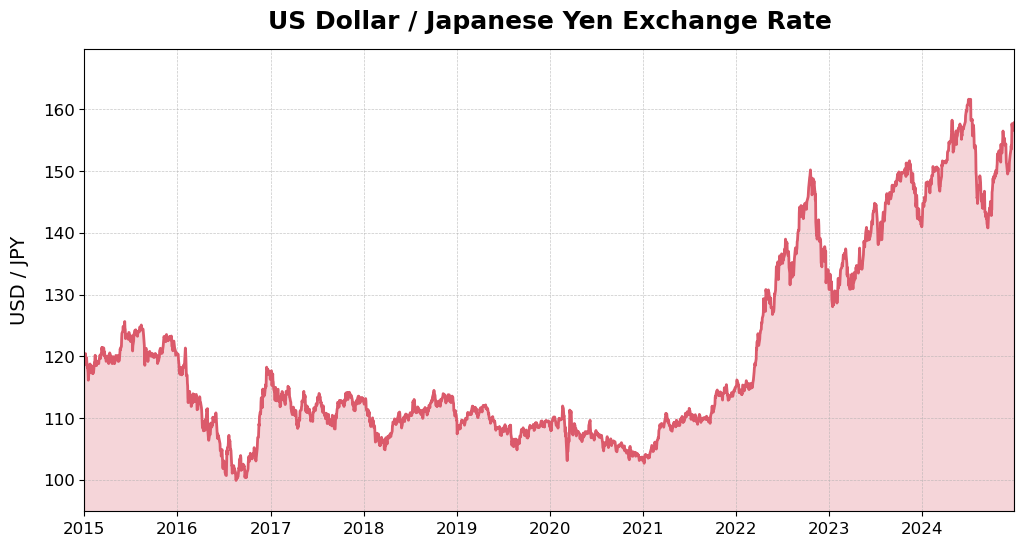

In [9]:
plt.figure(figsize=(12, 6))
plt.plot(yen['Date'], yen['Close'], color='#DB5A6B', lw=2, label='USD / JPY')
plt.fill_between(yen['Date'], yen['Close'], color='#DB5A6B', alpha=0.25)
plt.title('US Dollar / Japanese Yen Exchange Rate', fontsize=18, fontweight='bold', pad=15)
plt.ylabel('USD / JPY', fontsize=14, labelpad=10)
plt.xlim(min(yen['Date']), max(yen['Date']))
plt.ylim(min(yen['Close']) * 0.95, max(yen['Close']) * 1.05)
plt.grid(which='major', linestyle='--', lw=0.5, alpha=0.7)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.show()

Between 2015 and 2021, the exchange rate fluctuated between 100 JPY and 130 JPY per USD, trending downward. In 2022, the rate began to spike, eventually breaking past 160 JPY per USD by 2024. The surge in volatility post-2021 presents a challenge for forecasting models, which often perform better in more stable regimes. Hence the need to implement regime detection.

### Return and Volatility

To implement regime detection, we can look at grouping the datapoints by return and volatility.

Calculate the return as the percentage change from the previous day's return, and the volatility as the rolling volatility of a window of 20 days.

In [11]:
yen['Return'] = yen['Close'].pct_change() # Returns
yen['Volatility'] = yen['Return'].rolling(window=20).std() # Rolling Volatility
yen.dropna(inplace=True) # Drop missing values
yen[['Return', 'Volatility']] = StandardScaler().fit_transform(yen[['Return', 'Volatility']])

In [13]:
yen

Price,Date,Close,Return,Volatility
20,2015-01-29,117.592003,-0.302332,1.139099
21,2015-01-30,118.248001,0.979178,1.195845
22,2015-02-02,117.183998,-1.639877,1.247232
23,2015-02-03,117.574997,0.576353,1.190879
24,2015-02-04,117.646004,0.085357,1.139120
...,...,...,...,...
2600,2024-12-24,157.164993,0.702267,0.925928
2601,2024-12-25,157.106995,-0.089459,0.748168
2602,2024-12-26,157.132996,0.006582,0.443002
2603,2024-12-27,157.748001,0.680078,0.430588


Plot the normalized returns and volatility on a time-series graph.

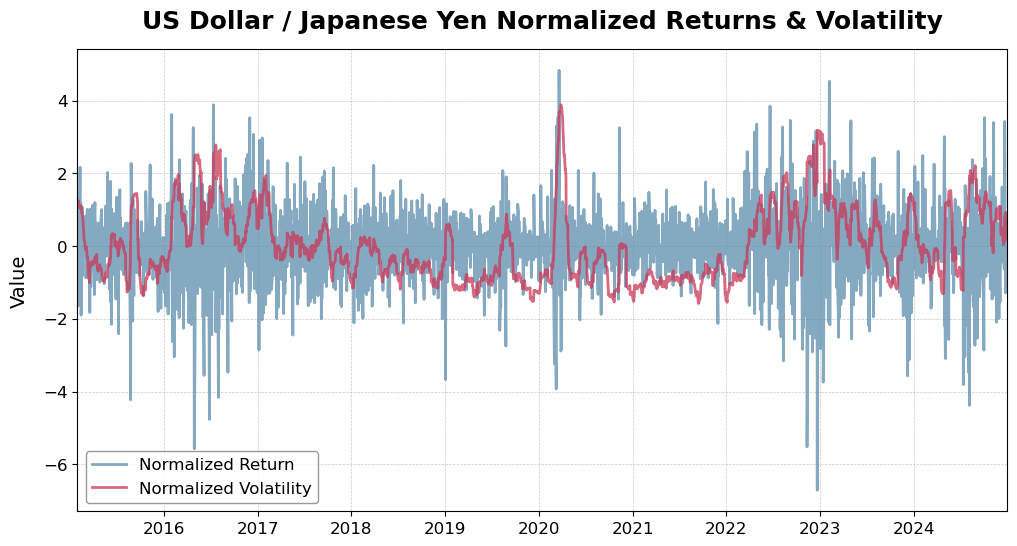

In [15]:
plt.figure(figsize=(12, 6))
plt.plot(yen['Date'], yen['Return'], color='#5D8CAE', lw=2, alpha=0.75, label='Normalized Return')
plt.plot(yen['Date'], yen['Volatility'], color='#C93756', lw=2, alpha=0.75, label='Normalized Volatility')
plt.title('US Dollar / Japanese Yen Normalized Returns & Volatility', fontsize=18, fontweight='bold', pad=15)
plt.ylabel('Value', fontsize=14, labelpad=10)
plt.xlim(min(yen['Date']), max(yen['Date']))
plt.grid(which='major', linestyle='--', lw=0.5, alpha=0.7)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.legend(fontsize=12, frameon=True, facecolor='white', edgecolor='gray', loc='lower left')
plt.show()

This plot shows clusters of increased/decreased return and volatility in 2016, early 2020, and the period from 2022 to 2023. 

## Regime Detection with $k$-Means Clustering

$k$-means clustering is used to identify market regimes given our return and volatility data. The elbow method is used to identify how many regimes are ideal. The choice of number of clusters ($k$) to use given the elbow method is arbitrary, and the number is usually determined on what the viewer finds ideal based on visual inspection.

### Elbow Method

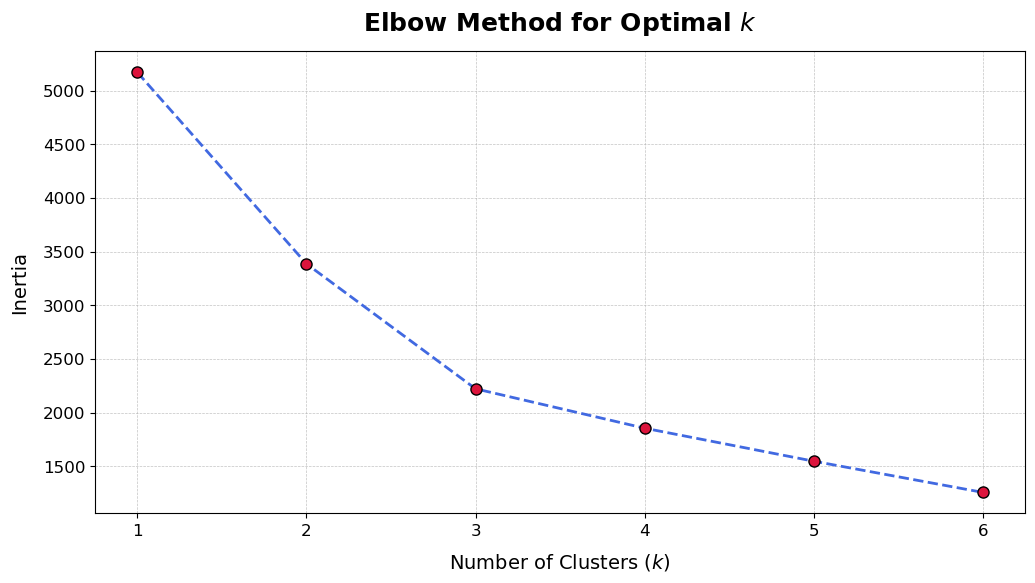

In [17]:
ke = range(1, 7)
inertias = []

for k in ke:
    model = KMeans(n_clusters=k)
    model.fit(yen[['Return', 'Volatility']])
    inertias.append(model.inertia_)

plt.figure(figsize=(12, 6))
plt.plot(ke, inertias, marker='o', color='royalblue', linestyle='--', lw=2, markersize=8, markerfacecolor='crimson', markeredgecolor='black')
plt.title('Elbow Method for Optimal $k$', fontsize=18, fontweight='bold', pad=15)
plt.xlabel('Number of Clusters ($k$)', fontsize=14, labelpad=10)
plt.ylabel('Inertia', fontsize=14, labelpad=10)
plt.grid(which='major', linestyle='--', lw=0.5, alpha=0.75)
plt.xticks(ke, fontsize=12)
plt.yticks(fontsize=12)
plt.show()

Looking at the plot, it can be observed that the optimal number of clusters is 3, as that is where the elbow point is. They should correspond to the three market regimes: Sideways, Bull, and Bear.

### Clustering

Now we can fit the $k$-means model with the optimal number of clusters ($k$).

In [19]:
kmeans_model = KMeans(n_clusters=3, random_state=120)
yen['K Regime'] = kmeans_model.fit_predict(yen[['Return', 'Volatility']])

Plot the returns compared to volatility colored by market regime.

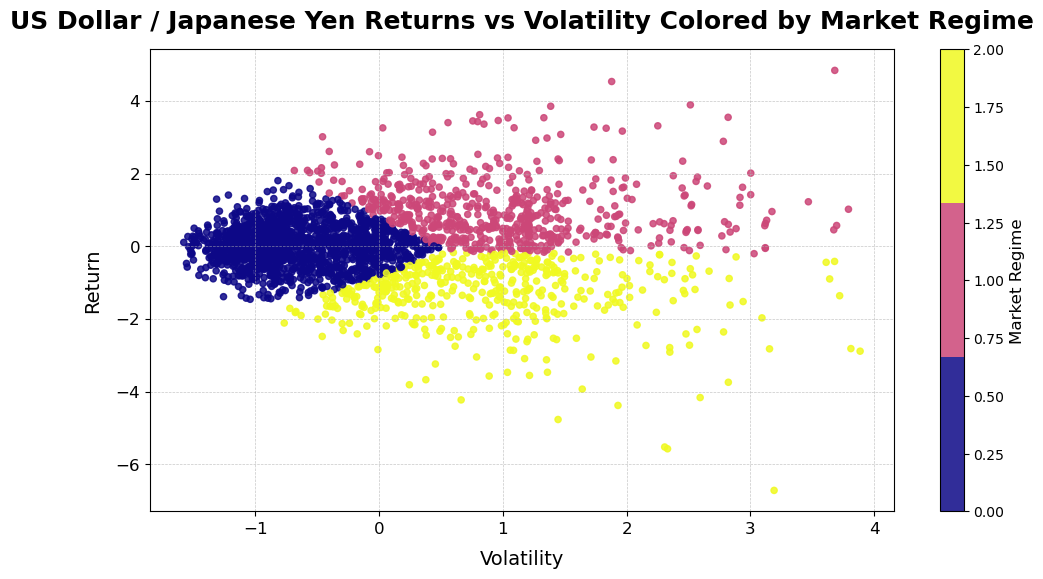

In [21]:
cmap = plt.colormaps['plasma'].resampled(3)
plt.figure(figsize=(12, 6))
scatter = plt.scatter(yen['Volatility'], yen['Return'], c=yen['K Regime'], cmap=cmap, s=20, alpha=0.85)
plt.title('US Dollar / Japanese Yen Returns vs Volatility Colored by Market Regime', fontsize=18, fontweight='bold', pad=15)
plt.xlabel('Volatility', fontsize=14, labelpad=10)
plt.ylabel('Return', fontsize=14, labelpad=10)
cbar = plt.colorbar(scatter)
cbar.set_label('Market Regime', fontsize=12)
plt.grid(which='major', linestyle='--', lw=0.5, alpha=0.7)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.show()

As shown, the $k$-means clustering appears to have created an imaginary line dividing each cluster, with one cluster representing low stable returns and lower volatility, another cluster representing higher returns and higher volatility, and a final cluster representing lower returns and higher volatility, they are labeled Regime 0, 1, and 2 in that order.

Now we can also plot the returns over time to see how each datapoint fits in the plot.

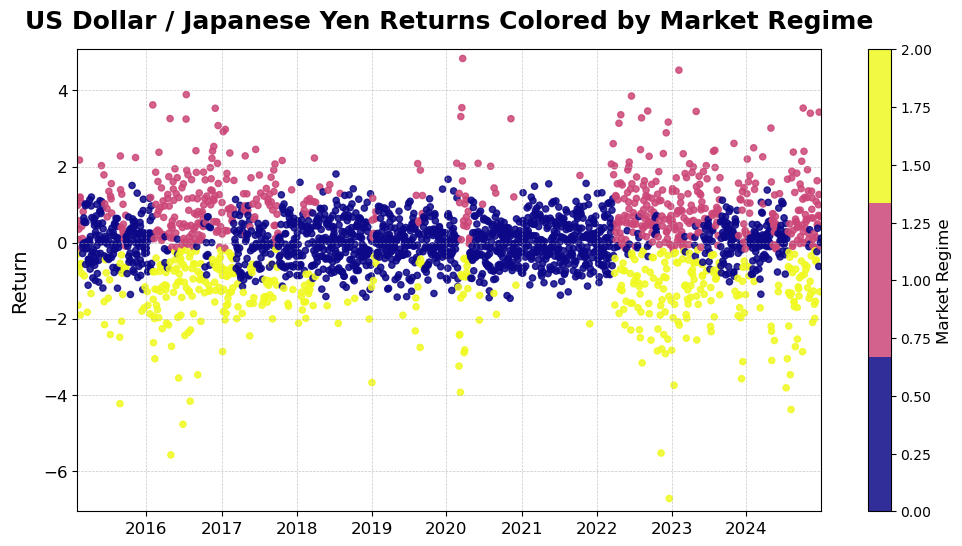

In [23]:
cmap = plt.colormaps['plasma'].resampled(3)
plt.figure(figsize=(12, 6))
scatter = plt.scatter(yen['Date'], yen['Return'], c=yen['K Regime'], cmap=cmap, s=20, alpha=0.85)
plt.title('US Dollar / Japanese Yen Returns Colored by Market Regime', fontsize=18, fontweight='bold', pad=15)
plt.ylabel('Return', fontsize=14, labelpad=10)
cbar = plt.colorbar(scatter)
cbar.set_label('Market Regime', fontsize=12)
plt.grid(which='major', linestyle='--', lw=0.5, alpha=0.7)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.xlim(min(yen['Date']), max(yen['Date']))
plt.ylim(min(yen['Return']) * 1.05, max(yen['Return']) * 1.05)
plt.show()

It's apparent again that Regime 0 represents stable returns with low volatility, Regime 1 represents higher returns with higher volatility, and Regime 2 represents lower returns with higher volatility.

In [25]:
yen

Price,Date,Close,Return,Volatility,K Regime
20,2015-01-29,117.592003,-0.302332,1.139099,2
21,2015-01-30,118.248001,0.979178,1.195845,1
22,2015-02-02,117.183998,-1.639877,1.247232,2
23,2015-02-03,117.574997,0.576353,1.190879,1
24,2015-02-04,117.646004,0.085357,1.139120,1
...,...,...,...,...,...
2600,2024-12-24,157.164993,0.702267,0.925928,1
2601,2024-12-25,157.106995,-0.089459,0.748168,1
2602,2024-12-26,157.132996,0.006582,0.443002,0
2603,2024-12-27,157.748001,0.680078,0.430588,1


### Regime Summary

Create a summary of the regimes.

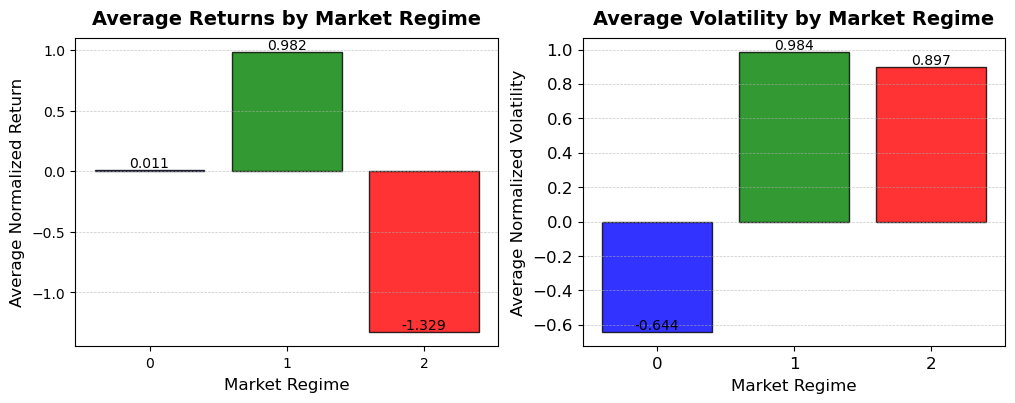

In [27]:
regime_summary = yen.groupby('K Regime').mean()[['Return', 'Volatility']]
# Define custom colors for the regimes
regime_colors = ['blue', 'green', 'red']

# Create a figure with two subplots side by side
fig, axes = plt.subplots(1, 2, figsize=(12, 4))

# Plot Average Returns by Market Regime
axes[0].set_title('Average Returns by Market Regime', fontsize=14, fontweight='bold', pad=10)
bars1 = axes[0].bar(regime_summary.index, regime_summary['Return'], color=regime_colors, alpha=0.8, edgecolor='black')
axes[0].set_xlabel('Market Regime', fontsize=12, labelpad=5)
axes[0].set_ylabel('Average Normalized Return', fontsize=12, labelpad=5)
axes[0].grid(axis='y', linestyle='--', lw=0.5, alpha=0.7)
axes[0].set_xticks([0, 1, 2]) # Ensure only absolute integer labels (0, 1, 2)

# Plot Average Volatility by Market Regime
axes[1].set_title('Average Volatility by Market Regime', fontsize=14, fontweight='bold', pad=10)
bars2 = axes[1].bar(regime_summary.index, regime_summary['Volatility'], color=regime_colors, alpha=0.8, edgecolor='black')
axes[1].set_xlabel('Market Regime', fontsize=12, labelpad=5)
axes[1].set_ylabel('Average Normalized Volatility', fontsize=12, labelpad=5)
axes[1].grid(axis='y', linestyle='--', lw=0.5, alpha=0.7)
axes[1].set_xticks([0, 1, 2]) # Ensure only absolute integer labels (0, 1, 2)

for bar in bars1:
    height = bar.get_height()
    axes[0].text(bar.get_x() + bar.get_width() / 2, height, f'{height:.3f}', ha='center', va='bottom', fontsize=10)
for bar in bars2:
    height = bar.get_height()
    axes[1].text(bar.get_x() + bar.get_width() / 2, height, f'{height:.3f}', ha='center', va='bottom', fontsize=10)

plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.show()

This again shows what has been stated in the previous analyses.

### Plot the Regimes

Create a time-series plot of the data, but color in the regimes.

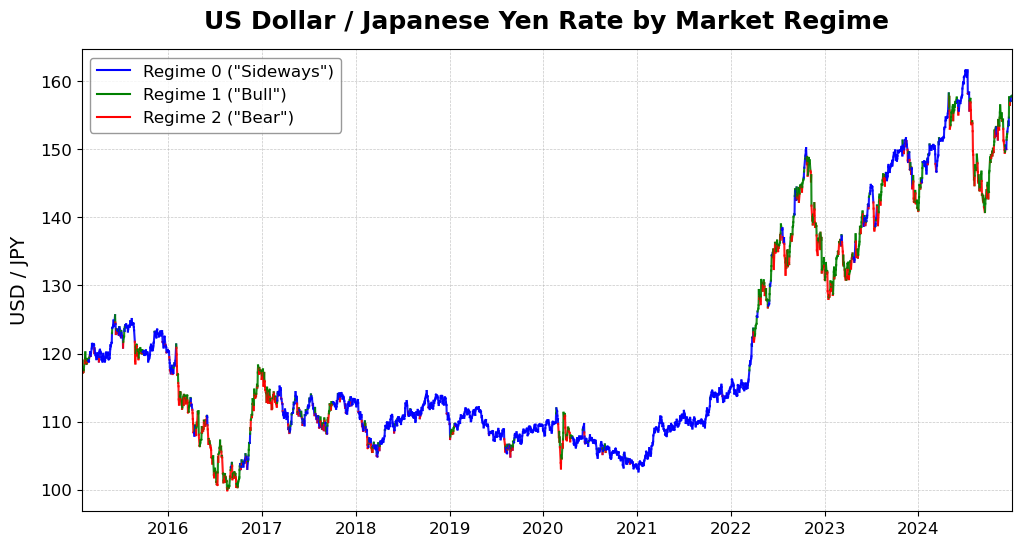

In [29]:
# Create a color map for the regimes
colors = {0: 'blue', 1: 'green', 2: 'red'}

plt.figure(figsize=(12, 6))
for i in range(1, len(yen.Close.values)):
    if yen['K Regime'].values[i] != yen['K Regime'].values[i-1]:  
        plt.plot(yen['Date'][i-1:i+1], yen.Close[i-1:i+1], 
                 color=colors[yen['K Regime'].values[i-1]], lw=1.5, alpha=0.9)
    else:  
        plt.plot(yen['Date'][i-1:i+1], yen.Close[i-1:i+1], 
                 color=colors[yen['K Regime'].values[i]], lw=1.5, alpha=0.9)
plt.title('US Dollar / Japanese Yen Rate by Market Regime', fontsize=18, fontweight='bold', pad=15)
plt.ylabel('USD / JPY', fontsize=14, labelpad=8)
plt.xlim(min(yen['Date']), max(yen['Date']))
plt.grid(which='major', linestyle='--', lw=0.5, alpha=0.7)
legend_elements = [Line2D([0], [0], color=colors[0], lw=1.5, label='Regime 0 ("Sideways")'),
                   Line2D([0], [0], color=colors[1], lw=1.5, label='Regime 1 ("Bull")'),
                   Line2D([0], [0], color=colors[2], lw=1.5, label='Regime 2 ("Bear")')]
plt.legend(handles=legend_elements, loc='upper left', fontsize=12, frameon=True, edgecolor='gray')
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.show()

Regime 0, aka sideways, is the most dominant, and it occurs when the exchange rate is most stable. Regime 1, aka bull, appears usually when the exchange rate rises more than normally and stops at the peak. Regime 2, aka bear, appears when the exchange rate falls suddenly and usually ends at a trough.

## Model

Now that we know what the data looks like, and we have the necessary features, we can prepare it for the predictive model.

In [31]:
test_size = yen[yen['Date'].dt.year >= 2020].shape[0]
scaler = MinMaxScaler()
window_size = 60

Plot the training set and testing set on a time-series graph. We are simply splitting the data in half.

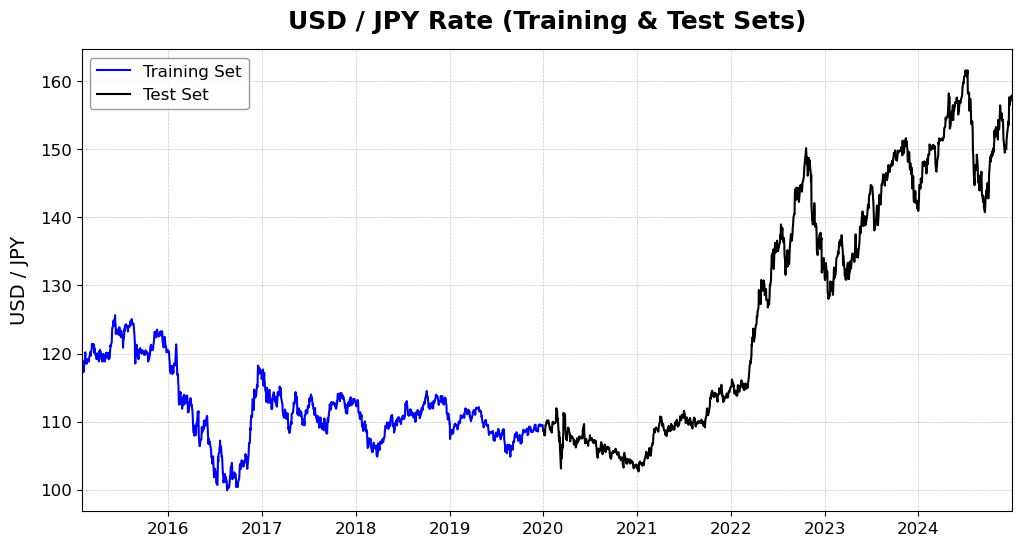

In [33]:
plt.figure(figsize=(12, 6))
plt.plot(yen['Date'][:-test_size], yen.Close[:-test_size], 
         label="Training Set", color='blue', lw=1.5)
plt.plot(yen['Date'][-test_size:], yen.Close[-test_size:], 
         label="Test Set", color='black', lw=1.5)
plt.title('USD / JPY Rate (Training & Test Sets)', fontsize=18, fontweight='bold', pad=15)
plt.ylabel('USD / JPY', fontsize=14, labelpad=8)
plt.xlim(min(yen['Date']), max(yen['Date']))
plt.grid(which='major', linestyle='--', lw=0.5, alpha=0.7)
plt.legend(fontsize=12, frameon=True, edgecolor='gray', loc='upper left')
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.show()

Define the training and testing sets by inputting the Close and Regime data. Scale the Close values to make it work better with the model.

In [35]:
train_data = yen[['Close', 'K Regime']][:-test_size]
test_data = yen[['Close', 'K Regime']][-test_size-window_size:]

# Scale the Close price
train_data['Close'] = scaler.fit_transform(train_data['Close'].values.reshape(-1,1))
test_data['Close'] = scaler.transform(test_data['Close'].values.reshape(-1,1))

# Prepare data with price and regime
train_data = np.concatenate([train_data['Close'].values.reshape(-1, 1), train_data['K Regime'].values.reshape(-1, 1)], axis=1)
test_data = np.concatenate([test_data['Close'].values.reshape(-1, 1), test_data['K Regime'].values.reshape(-1, 1)], axis=1)

# Check the size
train_data.size

2562

Prepare the training and testing sets. The goal is to predict prices for the next day.

In [37]:
# Training Set
X_train, y_train = [], []
for i in range(window_size, len(train_data)):
    X_train.append(train_data[i-window_size:i])
    y_train.append(train_data[i, 0]) # Next day

# Testing Set
X_test, y_test = [], []
for i in range(window_size, len(test_data)):
    X_test.append(test_data[i-window_size:i])
    y_test.append(test_data[i, 0]) # Next day

X_train = np.array(X_train)
X_test = np.array(X_test)
y_train = np.array(y_train)
y_test = np.array(y_test)

X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], len(train_data[0])))
X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], len(train_data[0])))

### LSTM Model

Now we can prepare and run the neural network. LSTM has been chosen for this project as its memory structure allows it to capture long-term dependencies and lag relationships, making it ideal for time-series datasets. The model architecture includes:

* **LSTM Layers**: Captures long-term dependencies from a 60-day input sequence. It returns the hidden state corresponding to the final time step, summarizing the past window.
* **Swish Activation (SiLU)**: An activation function at the end.
* **Dropout Layers**: Regularization layers applied to prevent overfitting.
* **Fully Connected Layers**: A stack of dense layers that transform the LSTM output into the final scalar prediction.

In [39]:
class LSTMModel(nn.Module):
    def __init__(self):
        super(LSTMModel, self).__init__()
        self.lstm = nn.LSTM(X_train.shape[2], 960, 3, batch_first=True, dropout=0.5)
        self.silu = nn.SiLU() # Swish Activation
        self.dropout = nn.Dropout(0.5) # Dropout
        self.fc1 = nn.Linear(960, 640)
        self.fc2 = nn.Linear(640, 320)
        self.fc3 = nn.Linear(320, 160)
        self.fc4 = nn.Linear(160, 1)
  
    def forward(self, x):
        x, _ = self.lstm(x) # LSTM layers
        x = x[:, -1, :] # Normalize Output
        x = self.fc1(x)
        x = self.dropout(x)
        x = self.fc2(x)
        x = self.dropout(x)
        x = self.fc3(x)
        x = self.dropout(x)
        x = self.fc4(x)
        x = self.silu(x) # Activation
        return x

This initializes the model and trains it over 10 epochs using the AdamW optimizer and mean squared error loss.

In [41]:
torch.manual_seed(120)

model = LSTMModel().to(device)
criterion = nn.MSELoss()
optimizer = optim.AdamW(model.parameters(), lr=0.0005, weight_decay=1e-4)

num_epochs = 10
batch_size = 50
train_losses, val_losses = [], []
epoch_times = []

X_train_tensor = torch.tensor(X_train, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train, dtype=torch.float32).view(-1, 1)
X_test_tensor = torch.tensor(X_test, dtype=torch.float32)
y_test_tensor = torch.tensor(y_test, dtype=torch.float32).view(-1, 1)
train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
test_dataset = TensorDataset(X_test_tensor, y_test_tensor)

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

for epoch in range(num_epochs):
    start_time = time.time()
    model.train()
    train_loss = 0
    for X_batch, y_batch in train_loader:
        X_batch, y_batch = X_batch.to(device), y_batch.to(device)
        optimizer.zero_grad()
        predictions = model(X_batch)
        loss = criterion(predictions, y_batch)
        loss.backward()
        optimizer.step()
        train_loss += loss.item() * X_batch.size(0)
    
    train_loss /= len(train_loader.dataset)
    train_losses.append(train_loss)
    
    # Validation Loss
    model.eval()
    val_loss = 0
    with torch.no_grad():
        for X_batch, y_batch in test_loader:
            X_batch, y_batch = X_batch.to(device), y_batch.to(device)
            predictions = model(X_batch)
            loss = criterion(predictions, y_batch)
            val_loss += loss.item() * X_batch.size(0)
    val_loss /= len(test_loader.dataset)
    val_losses.append(val_loss)
    end_time = time.time()
    epoch_times.append(end_time - start_time)
    
    print(f'Epoch {epoch + 1}, Training Loss: {train_loss:.4f}, Validation Loss: {val_loss:.4f}, Time: {epoch_times[-1]:.2f} seconds')

total_time = sum(epoch_times)
print(f"Total Time taken for training: {total_time:.2f} seconds")

Epoch 1, Training Loss: 0.0700, Validation Loss: 0.3851, Time: 42.88 seconds
Epoch 2, Training Loss: 0.0143, Validation Loss: 0.0347, Time: 40.33 seconds
Epoch 3, Training Loss: 0.0106, Validation Loss: 0.0159, Time: 41.68 seconds
Epoch 4, Training Loss: 0.0117, Validation Loss: 0.0351, Time: 41.92 seconds
Epoch 5, Training Loss: 0.0086, Validation Loss: 0.0076, Time: 42.23 seconds
Epoch 6, Training Loss: 0.0084, Validation Loss: 0.0071, Time: 40.67 seconds
Epoch 7, Training Loss: 0.0077, Validation Loss: 0.0159, Time: 39.93 seconds
Epoch 8, Training Loss: 0.0104, Validation Loss: 0.0172, Time: 42.60 seconds
Epoch 9, Training Loss: 0.0084, Validation Loss: 0.0684, Time: 43.65 seconds
Epoch 10, Training Loss: 0.0103, Validation Loss: 0.0020, Time: 39.03 seconds
Total Time taken for training: 414.92 seconds


Plot the training and validation loss over the epochs.

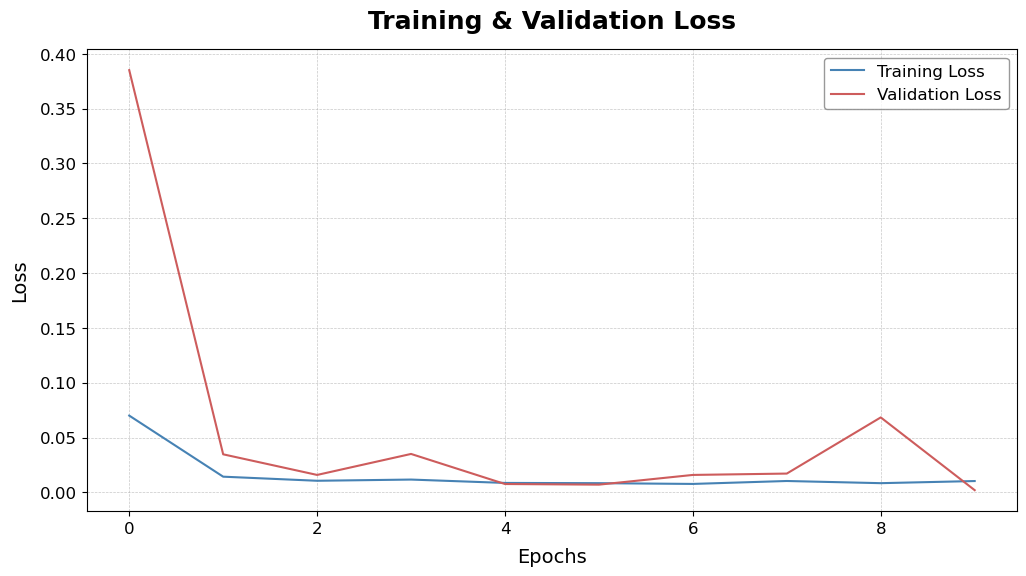

In [42]:
plt.figure(figsize=(12, 6))
plt.plot(train_losses, label='Training Loss', color='steelblue', lw=1.5)
plt.plot(val_losses, label='Validation Loss', color='indianred', lw=1.5)
plt.title('Training & Validation Loss', fontsize=18, fontweight='bold', pad=15)
plt.xlabel('Epochs', fontsize=14, labelpad=8)
plt.ylabel('Loss', fontsize=14, labelpad=8)
plt.grid(which='major', linestyle='--', lw=0.5, alpha=0.7)
plt.legend(fontsize=12, frameon=True, edgecolor='gray', loc='upper right')
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.show()

As shown, the model appears to learn rapidly with the validation loss falling quickly to meet the training loss.

### Model Results

Now we can test our results.

In [43]:
# Testing and Evaluation
model.eval()
with torch.no_grad():
    predictions = []
    for X_batch, _ in test_loader:
        X_batch = X_batch.to(device)
        preds = model(X_batch)
        predictions.extend(preds.cpu().numpy())

y_test_true = scaler.inverse_transform(y_test.reshape(-1, 1))
y_test_pred = scaler.inverse_transform(np.array(predictions).reshape(-1, 1))

Plot the predicted test set and compare the results to the actual test set.

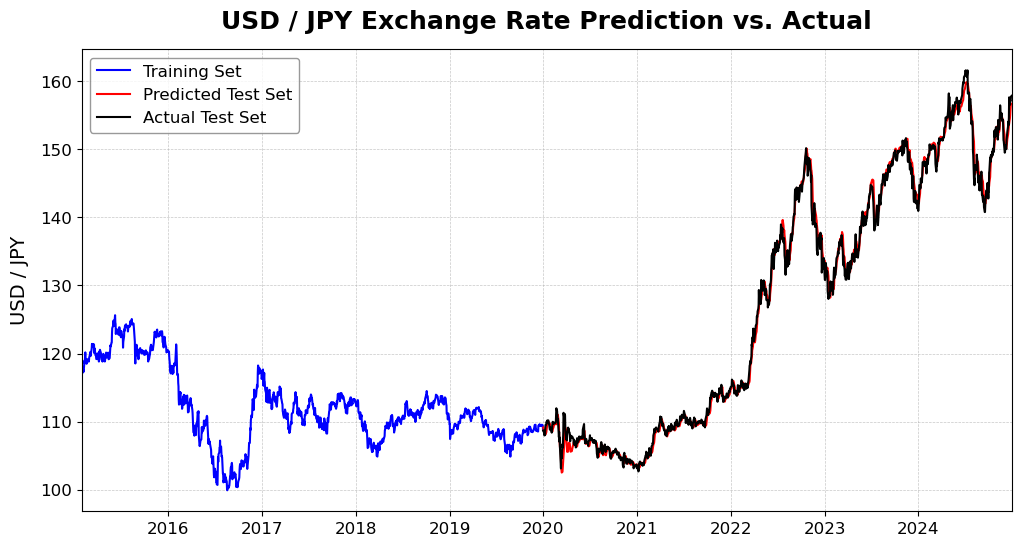

In [44]:
plt.figure(figsize=(12, 6))
plt.plot(yen['Date'][:-test_size], yen.Close[:-test_size], label="Training Set", color='blue', lw=1.5)
plt.plot(yen['Date'].iloc[-test_size:], y_test_pred, label="Predicted Test Set", color='red', lw=1.5)
plt.plot(yen['Date'].iloc[-test_size:], y_test_true, label="Actual Test Set", color='black', lw=1.5)
plt.title('USD / JPY Exchange Rate Prediction vs. Actual', fontsize=18, fontweight='bold', pad=15)
plt.ylabel('USD / JPY', fontsize=14, labelpad=8)
plt.xlim(min(yen['Date']), max(yen['Date']))
plt.grid(which='major', linestyle='--', lw=0.5, alpha=0.7)
plt.legend(fontsize=12, frameon=True, edgecolor='gray', loc='upper left')
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.show()

This visually appears to be a very good fit!

Now calculate the test loss and accuracy.

In [45]:
def test_model(model, X_test, y_test):
    model.eval()
    y_pred = model(torch.tensor(X_test).float().to(device))
    y_pred = y_pred.detach().cpu().numpy().flatten()
    
    test_loss = mean_absolute_error(y_test, y_pred)
    Accuracy = 1 - mean_absolute_percentage_error(y_test, y_pred)

    return y_pred, test_loss, Accuracy

y_test_pred1, test_loss, Accuracy = test_model(model, X_test, y_test)

print(f"Test Loss (MAE): {test_loss:.4f}")
print(f"Test Accuracy: {Accuracy:.4f}")

Test Loss (MAE): 0.0320
Test Accuracy: 0.9539


Excellent results!

### Save Results

Save the results into a new file.

In [46]:
prices = pd.DataFrame({
    'Date': yen['Date'].iloc[-test_size:].values,
    'Actual': y_test_true.flatten(),
    'Predicted': y_test_pred.flatten()
})

prices.to_csv('results.csv', index=False)
print("Prediction results saved to 'results.csv'")

Prediction results saved to 'results.csv'
